# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
from modules.SaturationAnalysis import SaturationAnalysis

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Performing Bayesian linear regression on EFT predictions


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 46 seconds.


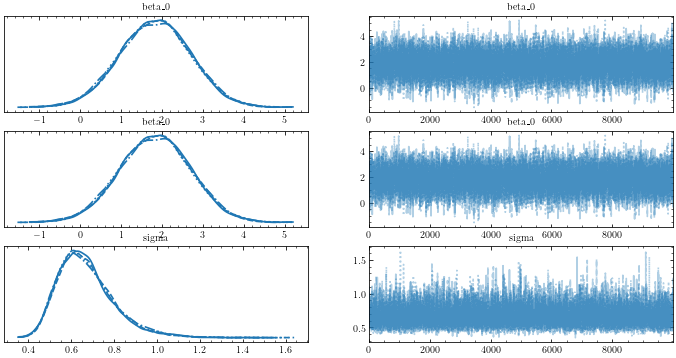

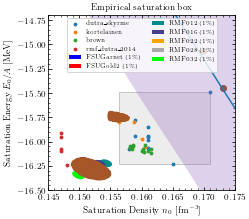

In [3]:
analysis = SaturationAnalysis()
analysis.plot_contraints(eft=True, eft_conf_level=0.95)

In [27]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(label="FSU-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])])
scenario2 = Scenario(label="FSU+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])
scenario3 = Scenario(label="all",
                     configs=[DataSetSampleConfig(data_set=dft_constraints[lbl]) for lbl in dft_constraints.keys()])
scenario4 = Scenario(label="Giuliani+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["Giuliani"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])

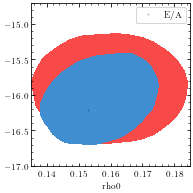

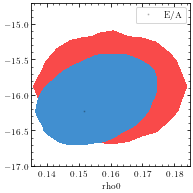

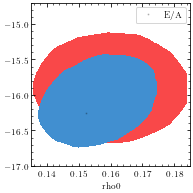

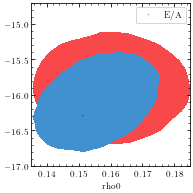

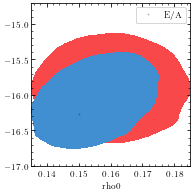

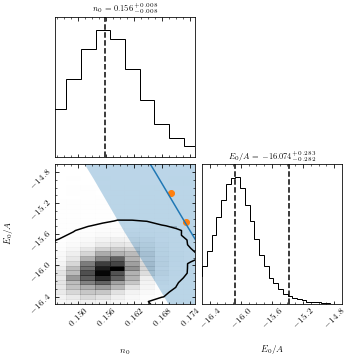

In [23]:
analysis.multiverse(scenario1)

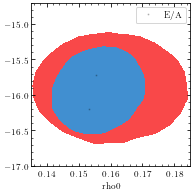

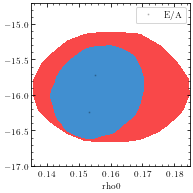

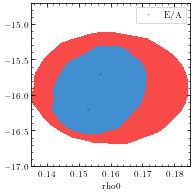

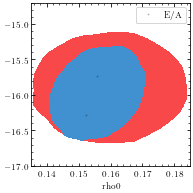

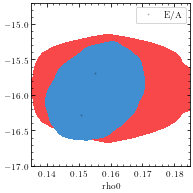

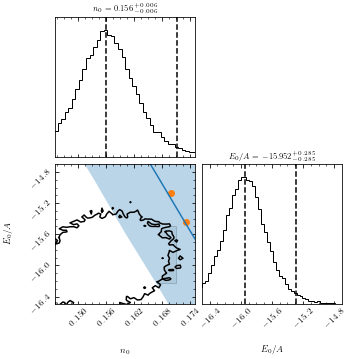

In [24]:
analysis.multiverse(scenario2)

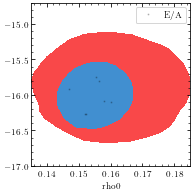

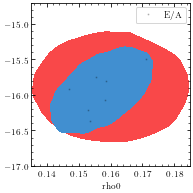

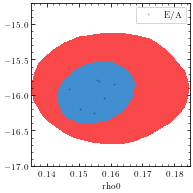

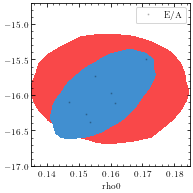

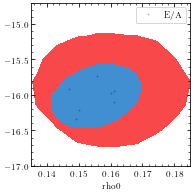

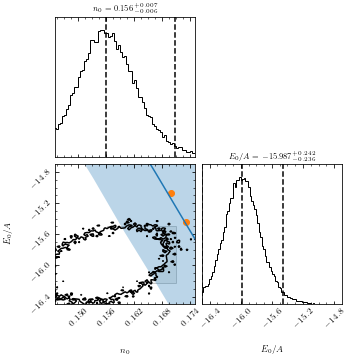

In [25]:
analysis.multiverse(scenario3)

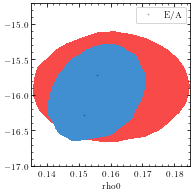

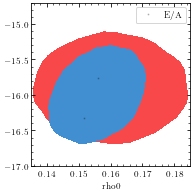

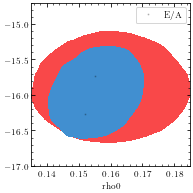

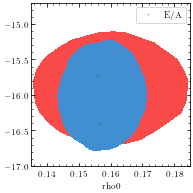

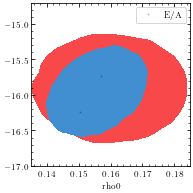

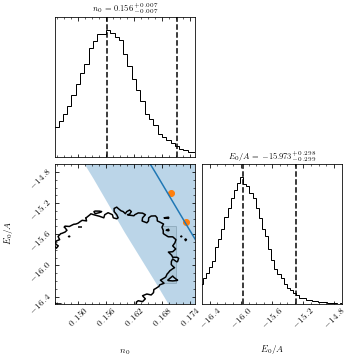

In [28]:
analysis.multiverse(scenario4)

Iterating over DFT constraints: 100%|██████████| 7/7 [05:13<00:00, 44.72s/it]


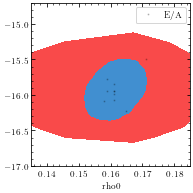

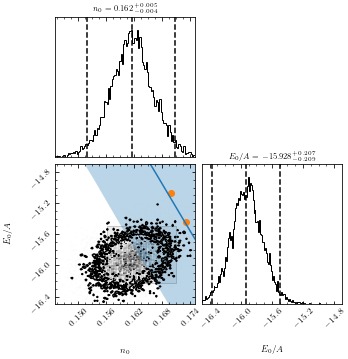

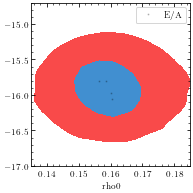

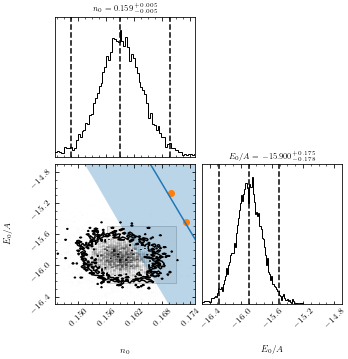

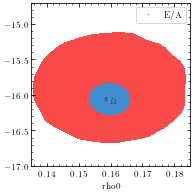

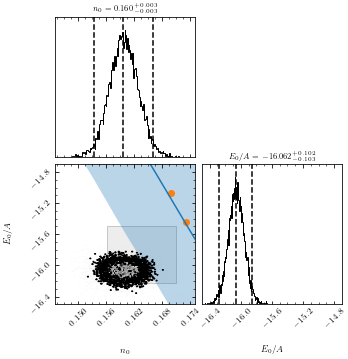

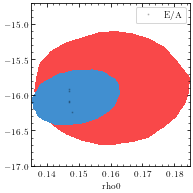

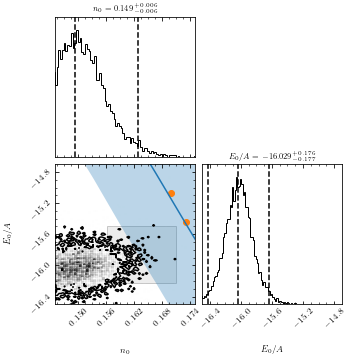

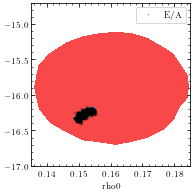

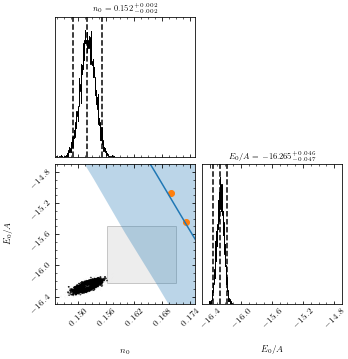

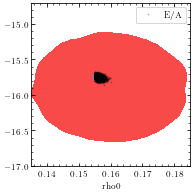

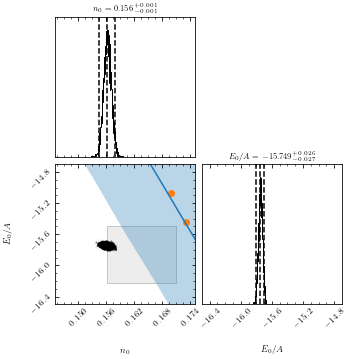

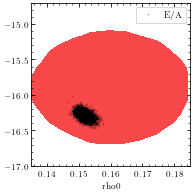

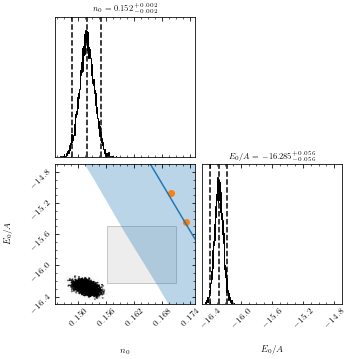

In [19]:
analysis.plot_individual_models()

## Old

In [3]:
from modules.DataSets import GenericDataSet, NormDistDataSet, KernelDensityEstimate
from modules.EftPredictions import *
from modules.StatisticalModel import StatisticalModel, multivariate_t, multivariate_normal, standard_prior_params
import matplotlib.backends.backend_pdf
from modules.DataSets import DataSetSampleConfig
from modules.StatisticalModel import model_from_scenario

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Set the location where pdf output will be stored.

In [24]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Constraints from density functional theory: data management

In [6]:
dft_constraints = {
    "Dutra_skyrme": GenericDataSet(filenames=["satpoints_dutra_skyrme.csv"]),
    "Kortelainen": GenericDataSet(filenames=["satpoints_kortelainen.csv"]),
    "Brown": GenericDataSet(filenames=["brown/satpoints_brown.csv"]),
    "Dutra_rmf": GenericDataSet(filenames=["satpoints_rmf_dutra_2014.csv"]),
    "FSU": NormDistDataSet(set_specifier="fsu_rmf"),
    "Schunck": KernelDensityEstimate(set_specifier="schunck")
}
# now add the saturation box from Drischler et al. (2016)
drischler = dft_constraints["Dutra_skyrme"] + dft_constraints["Kortelainen"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


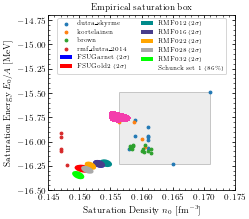

In [5]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/refactored_overview.pdf")
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 1.2*6.8*cm))
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)
pdf.savefig(fig)

for key, val in dft_constraints.items():
    val.plot(ax=ax)
    pdf.savefig(fig)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 44 seconds.


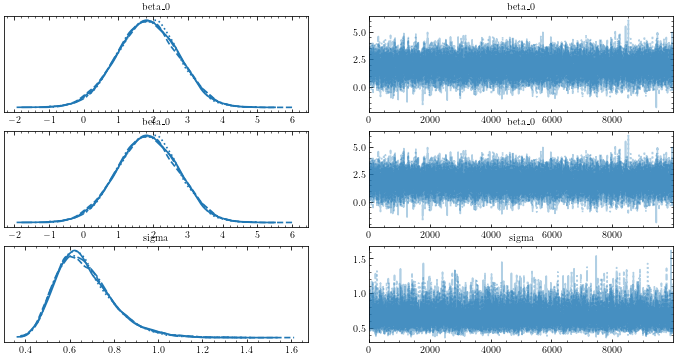

In [6]:
eft_pred = EftPredictions()
eft_pred.corner_plot()
eft_pred.plot(ax=ax)
pdf.savefig(fig)
pdf.close()

## Test case: single universe

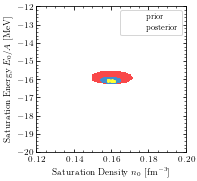

In [5]:
spoint=dft_constraints["Brown"].get_statistical_model(num_points=6)
# spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
spoint.plot(ax=ax, plot_data=True)

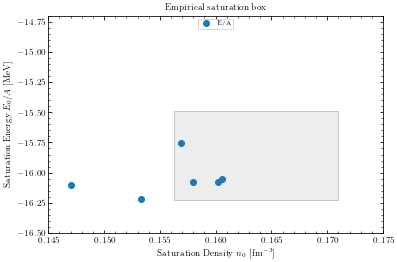

In [6]:
sampled_dft_constraints = pd.DataFrame()
for key, val in dft_constraints.items():
    sampled_dft_constraints = val.sample(df=sampled_dft_constraints, exclude=None, num_distr="all", num_points=1)

ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

In [7]:
sampled_dft_constraints  # one realization (aka "universe") for testing

,label,rho0,E/A,class,file
3,Ska35,0.158000,-16.080000,dutra_skyrme,satpoints_dutra_skyrme.csv
1,UNEDF0,0.160530,-16.056000,kortelainen,satpoints_kortelainen.csv
10,brown:11,0.160200,-16.078020,brown,brown/satpoints_brown.csv
3,BSR12,0.147000,-16.100000,rmf_dutra_2014,satpoints_rmf_dutra_2014.csv
0,RMF016,0.153339,-16.222400,fsu_rmf,data/Piekarewicz/RMF016/CovEllipse.com
4016,schunck:2,0.156900,-15.755223,schunck:2,data/Schunck/samples2.csv


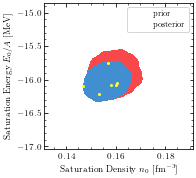

In [8]:
from modules.plot_helpers import cm
spoint = StatisticalModel(data=sampled_dft_constraints)
#spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
spoint.plot(ax=ax, num_samples=5000, set_xy_limits=False)
fig.savefig(f"{pdf_path}/output_single_universe.pdf")

In [26]:
scenario1 = [DataSetSampleConfig(data_set=dft_constraints["FSU"])]
scenario2 = scenario1 + [DataSetSampleConfig(data_set=dft_constraints["Schunck"])]
scenario3 = [DataSetSampleConfig(data_set=dft_constraints[lbl]) for lbl in dft_constraints.keys()]
scenario4 = [DataSetSampleConfig(data_set=dft_constraints["Brown"])]

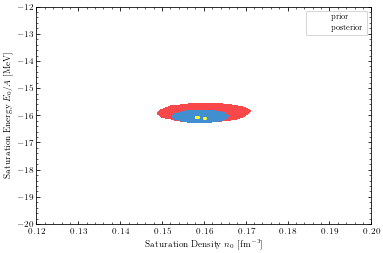

In [28]:
model = model_from_scenario(scenario=scenario3)
#ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
#drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)
model.plot(plot_data=True)

## Multiple Universes
Now, let's average over different realizations ("universes").

Multi-universe sampling: 100%|██████████| 5/5 [01:51<00:00, 22.40s/it]


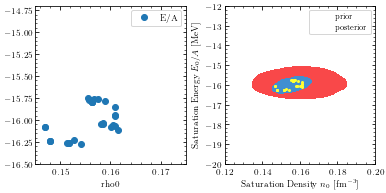

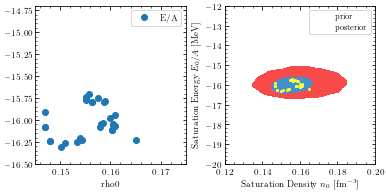

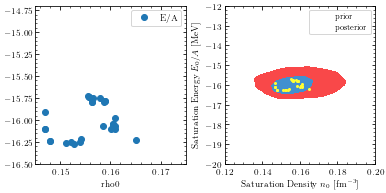

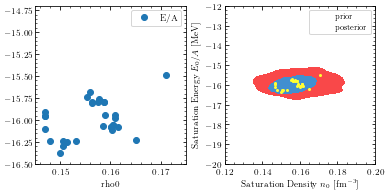

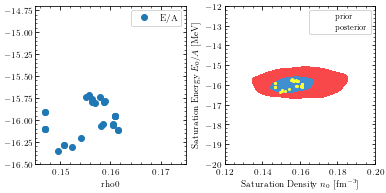

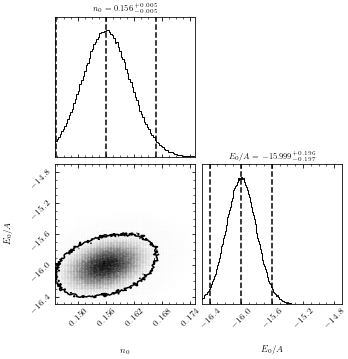

In [34]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/output_multi_universe.pdf")

from modules.MultiverseModeling import func
func(scenario3, pdf, num_realizations=5)
pdf.close()

In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/output_multi_universe.pdf")
num_realizations = 5
samples = pd.DataFrame()

for irealiz in tqdm(range(num_realizations), desc="Multi-universe sampling"):
    # set up canvas
    fig, axs = plt.subplots(1, 2, figsize=(2*6.8*cm, 6.8*cm), constrained_layout=True)

    # construct data set ("universe") for Bayesian inference
    sampled_dft_constraints = pd.DataFrame()
    for key, val in dft_constraints.items():
        sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

    # plot raw data (left panel)
    sampled_dft_constraints.plot(ax=axs[0], x="rho0", y="E/A", linestyle="None", marker="o")
    for ax in axs:  # draw saturation box in both panels as a reference
        drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True,
                       add_legend=False, add_axis_labels=False)
    axs[0].set_xlim(0.145, 0.175)
    axs[0].set_ylim(-16.5, -14.7)

    # perform Bayesian analysis
    spoint = StatisticalModel(data=sampled_dft_constraints,
                              quantities=["rho0", "E/A"],
                              prior_params=standard_prior_params)
    #print(spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True))

    # store data from current universe (for universe-averaging later on)
    tmp = spoint.sample_predictive_bf(return_predictive_only=False, based_on="posterior",
                                      num_samples=1, num_samples_mu_Sigma=100000)  # 100000
    tmp["universe"] = irealiz
    samples = pd.concat((samples, tmp))

    # plot predictive prior and predictive posterior (right panel)
    spoint.plot(ax=axs[1], num_samples=500000)  #500000
    pdf.savefig(fig)

# plot multi-universe average of the posterior predictive
names = ["predictive rho0", "predictive E/A"]
labels = [r"$n_0$", r"$E_0/A$"]
n_std = 2 # e.g., 86% will correspond to 2 sigma in 2 dimensions
fig, axs = plt.subplots(2, 2, figsize=(2*6.8*cm, 2*6.8*cm))
corner.corner(samples, var_names=names, labels=labels,
              quantiles=(0.025, 0.5, 0.975),  # TODO: 2 sigma hard-coded
              title_quantiles=(0.025, 0.5, 0.975),
              levels=(1 - np.exp(-n_std**2 / 2),),
              bins=200,
              plot_datapoints=False, plot_density=True,
              show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 8}, fig=fig)
drischler.plot(ax=axs[1, 0], plot_scatter=False, plot_box_estimate=True,
               add_legend=False, add_axis_labels=False)
eft_pred.plot(ax=axs[1, 0])

axs[0, 0].set_xlim(0.145, 0.175)
axs[1, 0].set_xlim(0.145, 0.175)
axs[1, 0].set_ylim(-16.5, -14.7)
axs[1, 1].set_xlim(-16.5, -14.7)

pdf.savefig(fig)
pdf.close()

Multi-universe sampling:  20%|██        | 1/5 [06:03<24:12, 363.14s/it]

Let's take a look at the plain data from the different universes.

In [38]:
samples

,predictive rho0,predictive E/A,mu rho0,mu E/A,"Sigma (0,0)","Sigma (0,1)","Sigma (1,1)",universe
0,0.143892,-16.042639,0.154314,-15.861061,0.000039,0.000174,0.035090,0
1,0.161872,-16.400111,0.160705,-15.932884,0.000042,-0.000343,0.081829,0
2,0.166229,-16.160055,0.154712,-15.916205,0.000024,-0.000208,0.048252,0
3,0.154831,-16.006646,0.154203,-15.905837,0.000014,-0.000097,0.070777,0
4,0.147742,-16.306258,0.155126,-16.079118,0.000025,-0.000110,0.095353,0
...,...,...,...,...,...,...,...,...
99995,0.157412,-15.872726,0.158059,-16.066370,0.000033,0.001146,0.068887,4
99996,0.153379,-16.339057,0.154397,-16.032097,0.000021,0.000078,0.026579,4
99997,0.153701,-15.997642,0.157469,-16.052953,0.000011,0.000351,0.033137,4
99998,0.151062,-16.346234,0.157698,-16.071519,0.000118,0.001413,0.050989,4


Interesting! Look at the off-diagonal component of $\Sigma$, i.e., `Sigma (0,1)`. It's close to zero and changes sign. Why don't we obtain the saturation density and energy uncorrelated? Is that because of the chosen prior or prior paramaters?

In [252]:
def func(x1, x2):  # r, theta
    ret = multivariate_normal.pdf( mean=(0,0), x=[x1*np.cos(x2), x1*np.sin(x2)], cov=np.array([[1,0*0.99], [0*0.99,1]])) * x1
    #print([x1*np.cos(x2), x1*np.sin(x2)], ret)
    return ret
integrate.dblquad(func, a=0, b=2*np.pi,
                        gfun= lambda x: 0, hfun=2, args=(), epsabs=1.49e-06, epsrel=1.49e-06)

(0.8646647167633874, 9.599706771317023e-15)

In [235]:
np.linalg.norm([2*np.cos(0.2), 2*np.sin(0.2)], 2)

2.0

In [236]:
np.pi*10**2

314.1592653589793

In [48]:
from scipy import interpolate
def conf_int(grid_y, grid_x, level):
    intpf = interpolate.interp1d(grid_x, grid_y, kind='cubic') # r(theta)
    #print(grid_x, grid_y)
    def intpff(x):
        print(x/(2.*np.pi))
        ret = np.max([intpf(x), -np.inf])
        #print(x/np.pi, ret)
        return ret
    #print(intpf(0), intpf(np.pi/2))
    def func(x1, x2):  # r, theta
        # ret = multivariate_t.pdf(df=prior_params["nu"],
        #                           loc=prior_params["mu"]*0,
        #                           shape=prior_params["Psi"],
        #                           x=[x1*np.cos(x2), x1*np.sin(x2)]) * x1
        ret = multivariate_normal.pdf( mean=(0,0), cov=np.array([[1,0.99*0.99], [0.99*0.99,1]]), #np.diag([1,4]),
                                       x=[x1*np.cos(x2), x1*np.sin(x2)])
        #print([x1*np.cos(x2), x1*np.sin(x2)])
        #print("ret", ret)
        return ret * x1
    res = integrate.dblquad(func, a=0, b=2*np.pi,
                            gfun= lambda x: 0, hfun=intpff, args=(), epsabs=1.49e-06, epsrel=1.49e-06)
                            #gfun= lambda x: 0, hfun=lambda x: 5, args=(), epsabs=1.49e-06, epsrel=1.49e-06)
    #print(res)
    print("res", grid_y, res)
    return res[0] - level

In [49]:
from scipy import integrate
from scipy import optimize
num_points=5
grid = np.linspace(0, 2.*np.pi, num_points)
def find_2d_cov_region(start, level=0.68):
    sol = optimize.newton(conf_int, x0=np.ones(num_points)*1.5, fprime=None, args=(grid, level), tol=1.48e-04,
                    maxiter=50, fprime2=None, x1=None, rtol=0.0, full_output=False, disp=True)
    return sol

xx = find_2d_cov_region(start=0, level=0.5) #0.393)

0.5
0.013046735741414116
0.986953264258586
0.06746831665550773
0.9325316833444922
0.1602952158504878
0.8397047841495122
0.2833023029353764
0.7166976970646236
0.42556283050918436
0.5744371694908156
0.0021714184870959287
0.9978285815129041
0.03492125432214585
0.9650787456778542
0.10959113670679155
0.8904088632932086
0.21862143266569767
0.7813785673343023
0.35280356864926987
0.6471964313507301
0.25
0.006523367870707058
0.493476632129293
0.033734158327753866
0.4662658416722461
0.0801476079252439
0.4198523920747561
0.1416511514676882
0.3583488485323118
0.21278141525459218
0.2872185847454078
0.0010857092435479644
0.49891429075645205
0.017460627161072925
0.4825393728389271
0.054795568353395774
0.4452044316466043
0.10931071633284883
0.39068928366715117
0.17640178432463494
0.32359821567536506
0.75
0.5065233678707071
0.9934766321292929
0.5337341583277538
0.9662658416722462
0.5801476079252439
0.9198523920747561
0.6416511514676883
0.8583488485323117
0.7127814152545922
0.7872185847454078
0.50108570

In [50]:
xx
#grid

array([0.95971567, 0.95971567, 0.95971567, 0.95971567, 0.95971567])

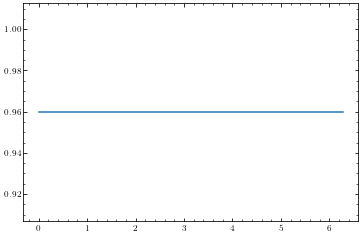

In [51]:
plt.plot(grid, xx )

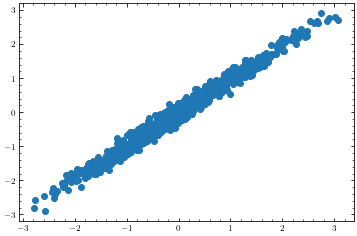

In [17]:
#plt.plot(grid, xx)
dat=multivariate_normal.rvs( mean=(0,0), cov=np.array([[1,0.99], [0.99,1]]), #np.diag([1,4]),
                             size=1000)
plt.scatter(dat[:,0], dat[:,1] )

In [ ]:
# Return the double (definite) integral of func(y, x) from x = a..b and y = gfun(x)..hfun(x).